In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from pathlib import Path
import torch
import pickle 
import os

from modules.elbo import ELBO

### Run curvature estimation for 100 different trajectories to test recovery 

In [2]:
sim_idx = 0 # which out of the 100 simulated trajectories to use
n_traj = 100
data_path = Path('data')
# c_true = np.zeros(n_traj) # simulated global curvature
# c_est = np.zeros(n_traj)  # average estimated local curvature

for i in range(50, n_traj):
    # load data
    f_name = f'sim_{str(i+1).zfill(4)}.mat'
    S = spio.loadmat(Path(data_path) / f_name)['S']
    S_list = [S[0, i] for i in range(S.shape[1])]  # convert to list of structs
    c_true = S_list[sim_idx]['generative_params'][0][0]['c_mu'][0][0][0]
    
    # unpack data
    n_corr_obs = S_list[sim_idx]['Pc_reshaped'][0, 0] * S_list[sim_idx]['num_trials_mat'][0, 0]
    n_total_obs = S_list[sim_idx]['num_trials_mat'][0, 0]
    n_frames = S_list[sim_idx]['Pc_reshaped'][0, 0].shape[0]
    n_dim = 10
    # n_dim = S_list[sim_idx]['x'][0, 0].shape[0]

    elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=20000, verbose=False)
    x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post = elbo.optimize_ELBO_SGD()
    # c_est[i] = torch.rad2deg(torch.mean(elbo.mu_post_c)).detach().numpy()

    # save estimated values
    save_data = {'x_true': S_list[sim_idx]['x'][0, 0],
                'x_pred': x,
                'perf_true': S_list[sim_idx]['Pc_reshaped'][0, 0],
                'perf_pred': p.detach().squeeze(),
                'c_true_sim': np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten(), 
                'c_post': torch.flatten(torch.rad2deg(elbo.mu_post_c)).detach(),
                'c_true': c_true}

    f_name = Path('data') / 'curvatures' / f'curvature_{str(i+1).zfill(4)}.pkl'
    with open(f_name, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"Trajectory: {i}")

Running MLE to initialize posterior..........................
Trajectory: 50
Running MLE to initialize posterior..........................
Trajectory: 51
Running MLE to initialize posterior..........................
Trajectory: 52
Running MLE to initialize posterior..........................
Trajectory: 53
Running MLE to initialize posterior..........................


KeyboardInterrupt: 

### Plot recovery

In [7]:
dir_path = Path('data') / 'curvatures'
c_true = np.zeros(len(os.listdir(dir_path)))
c_est = np.zeros(len(os.listdir(dir_path)))

for i, file in enumerate(os.listdir(dir_path)):
    with open(Path(dir_path) / file, 'rb') as f:
        loaded_data = pickle.load(f)
    c_true[i] = np.mean(loaded_data['c_true_sim'])
    c_est[i] = np.mean(loaded_data['c_post'].numpy())

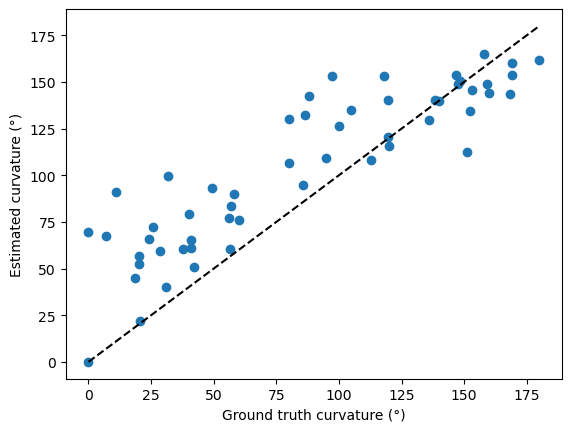

In [15]:
plt.scatter(c_true, c_est)
plt.plot([0, 180], [0, 180], 'k--')
plt.xlabel('Ground truth curvature (°)')
plt.ylabel('Estimated curvature (°)')
plt.show()